Twitter Application Analysis
---------------------------------------

Sailahari Seethamraju - 016037112


In [5]:
import pandas as pd
import numpy as np
import time
from time import sleep

# Getting tweets from twitter

In [11]:
import tweepy
from tweepy import OAuthHandler
class TwitterClient(object): 
    def __init__(self):
        # Access Credentials 
        consumer_key = 'GXiPV0P6hJenfSfOHwHi3qfAR'
        consumer_secret = 'AAGUf3AkwHHtICARCBuoirCnBtfPQEquGsQH7HVPOnPrq6Mu5G'
        access_token = '1520529519374786560-ynmwaEA5FEelmUsO0Etcx89PEpnSKF'
        access_token_secret = '2yNBlLypZEF1g4G6DM8S6bTHrvYHAhWWCOuLlwcDe20wq'
        try: 
            # OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Twitter Authentication Failed - \n{str(e)}") 

    # Function to fetch tweets
    def get_tweets(self, query, maxTweets = 1000): 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100
        
        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break
                    
                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [12]:
selenium_client = TwitterClient()

tweets_df = selenium_client.get_tweets('environment')

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets


In [13]:
tweets_df.head()

,tweets
0,"@ainunrozi pemaaf sih ak mah, cm ya gamau kena..."
1,RT @Nyanfood: environment work for @isavtuber ...
2,RT @TRU_Lab: Fascinating book by #IanSanjayPat...
3,RT @FrancisSuarez: As someone who is pro #bitc...
4,RT @down_with_putin: @Nestle is one of the wor...


# Pre Processing 

In [14]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    if polarity_scores['neg'] > polarity_scores['pos']:
        return 'negative'
    else:
        return 'positive'

def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    # set sentiment 
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0: 
        return 'negative'
    else:
        return 'neutral'

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [15]:
import re
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")

In [16]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split()        if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets

In [17]:
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)

,tweets,tidy_tweets
0,"@ainunrozi pemaaf sih ak mah, cm ya gamau kena...","@ainunrozi pemaaf sih ak mah, cm ya gamau kena..."
1,RT @Nyanfood: environment work for @isavtuber ...,environment work for @isavtuber figure art by ...
2,RT @TRU_Lab: Fascinating book by #IanSanjayPat...,Fascinating book by #IanSanjayPatel of @bbkpsy...
3,RT @FrancisSuarez: As someone who is pro #bitc...,As someone who is pro #bitcoin and cares about...
4,RT @down_with_putin: @Nestle is one of the wor...,@Nestle is one of the worst companies in the w...
...,...,...
645,"@SorexOrnatus ""Like a clam"" is a good metaphor...","@SorexOrnatus ""Like a clam"" is a good metaphor..."
646,It's starting to become a more analyzing situa...,It's starting to become a more analyzing situa...
647,RT @urbangridlock: Had a lovely afternoon at S...,Had a lovely afternoon at Spike Island. Great ...
648,@greenwoodPG1 @pelesburner Impossible to compa...,@greenwoodPG1 @pelesburner Impossible to compa...


In [18]:
tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [19]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_set = set(stopwords.words("english"))
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))

tweets_df['absolute_tidy_tweets'] = cleaned_tweets

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [21]:
from nltk.stem import WordNetLemmatizer
# Tokenization
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
# Finding Lemma for each word
word_lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
#joining words into sentences (from where they came from)
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet

In [22]:
tweets_df

,tweets,tidy_tweets,absolute_tidy_tweets
0,"@ainunrozi pemaaf sih ak mah, cm ya gamau kena...","@ainunrozi pemaaf sih ak mah, cm ya gamau kena...",ainunrozi pemaaf sih ak mah cm ya gamau kenal ...
1,RT @Nyanfood: environment work for @isavtuber ...,environment work for @isavtuber figure art by ...,environment work isavtuber figure art clay ysr...
2,RT @TRU_Lab: Fascinating book by #IanSanjayPat...,Fascinating book by #IanSanjayPatel of @bbkpsy...,Fascinating book #IanSanjayPatel bbkpsychosoci...
3,RT @FrancisSuarez: As someone who is pro #bitc...,As someone who is pro #bitcoin and cares about...,As someone pro #bitcoin care environment I urg...
4,RT @down_with_putin: @Nestle is one of the wor...,@Nestle is one of the worst companies in the w...,Nestle one worst company world In addition pro...
...,...,...,...
645,"@SorexOrnatus ""Like a clam"" is a good metaphor...","@SorexOrnatus ""Like a clam"" is a good metaphor...",SorexOrnatus Like clam good metaphor If shell ...
646,It's starting to become a more analyzing situa...,It's starting to become a more analyzing situa...,Its starting become analyzing situation Ventur...
647,RT @urbangridlock: Had a lovely afternoon at S...,Had a lovely afternoon at Spike Island. Great ...,Had lovely afternoon Spike Island Great see EA...
648,@greenwoodPG1 @pelesburner Impossible to compa...,@greenwoodPG1 @pelesburner Impossible to compa...,greenwoodPG pelesburner Impossible compare act...


In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english', max_features=50)
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english', max_features=50)
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df['absolute_tidy_tweets'])

In [24]:
bow_word_feature

<650x50 sparse matrix of type '<class 'numpy.int64'>'
	with 977 stored elements in Compressed Sparse Row format>

In [25]:
tweets_df

,tweets,tidy_tweets,absolute_tidy_tweets
0,"@ainunrozi pemaaf sih ak mah, cm ya gamau kena...","@ainunrozi pemaaf sih ak mah, cm ya gamau kena...",ainunrozi pemaaf sih ak mah cm ya gamau kenal ...
1,RT @Nyanfood: environment work for @isavtuber ...,environment work for @isavtuber figure art by ...,environment work isavtuber figure art clay ysr...
2,RT @TRU_Lab: Fascinating book by #IanSanjayPat...,Fascinating book by #IanSanjayPatel of @bbkpsy...,Fascinating book #IanSanjayPatel bbkpsychosoci...
3,RT @FrancisSuarez: As someone who is pro #bitc...,As someone who is pro #bitcoin and cares about...,As someone pro #bitcoin care environment I urg...
4,RT @down_with_putin: @Nestle is one of the wor...,@Nestle is one of the worst companies in the w...,Nestle one worst company world In addition pro...
...,...,...,...
645,"@SorexOrnatus ""Like a clam"" is a good metaphor...","@SorexOrnatus ""Like a clam"" is a good metaphor...",SorexOrnatus Like clam good metaphor If shell ...
646,It's starting to become a more analyzing situa...,It's starting to become a more analyzing situa...,Its starting become analyzing situation Ventur...
647,RT @urbangridlock: Had a lovely afternoon at S...,Had a lovely afternoon at Spike Island. Great ...,Had lovely afternoon Spike Island Great see EA...
648,@greenwoodPG1 @pelesburner Impossible to compa...,@greenwoodPG1 @pelesburner Impossible to compa...,greenwoodPG pelesburner Impossible compare act...


In [26]:
for row in tweets_df.itertuples():
    tweet = tweets_df.at[row[0], 'absolute_tidy_tweets']
    result=fetch_sentiment_using_textblob(tweet)
    tweets_df.at[row[0], 'Sentiment']=result

In [27]:
tweets_df['Sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [28]:
tweets_df.head(100)

,tweets,tidy_tweets,absolute_tidy_tweets,Sentiment
0,"@ainunrozi pemaaf sih ak mah, cm ya gamau kena...","@ainunrozi pemaaf sih ak mah, cm ya gamau kena...",ainunrozi pemaaf sih ak mah cm ya gamau kenal ...,neutral
1,RT @Nyanfood: environment work for @isavtuber ...,environment work for @isavtuber figure art by ...,environment work isavtuber figure art clay ysr...,neutral
2,RT @TRU_Lab: Fascinating book by #IanSanjayPat...,Fascinating book by #IanSanjayPatel of @bbkpsy...,Fascinating book #IanSanjayPatel bbkpsychosoci...,positive
3,RT @FrancisSuarez: As someone who is pro #bitc...,As someone who is pro #bitcoin and cares about...,As someone pro #bitcoin care environment I urg...,neutral
4,RT @down_with_putin: @Nestle is one of the wor...,@Nestle is one of the worst companies in the w...,Nestle one worst company world In addition pro...,negative
...,...,...,...,...
95,@GOC_Wrestling WWE's environment tells you tha...,@GOC_Wrestling WWE's environment tells you tha...,GOCWrestling WWEs environment tell risk gettin...,neutral
96,RT @AdrianRamsay: Great sessions out canvassin...,Great sessions out canvassing with @NorwichGre...,Great session canvassing NorwichGreens eally p...,positive
97,RT @boojieshay: Switch your environment up bec...,Switch your environment up because sometimes y...,Switch environment sometimes see,neutral
98,"There are also giant bettas, which will need a...","There are also giant bettas, which will need a...",There also giant bettas need minimum gallon mo...,neutral


In [29]:
target_variable = tweets_df['Sentiment'].apply(lambda x: 0 if x=='negative' else 1 if x=='positive' else -1 )

# Modeling

## Gaussian NB

In [40]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics

def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)
    import joblib
    from joblib import dump

    # dump the pipeline model
    dump(naive_classifier, filename="text_classification.joblib")
    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())
    
    # calculating f1 score
    accuracy=metrics.accuracy_score(predictions,y_test)
    print(f'Accuracy Score - {accuracy}')

In [41]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=870)
naive_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.24102564102564103


In [42]:
X_train

<455x50 sparse matrix of type '<class 'numpy.int64'>'
	with 701 stored elements in Compressed Sparse Row format>

In [43]:
X_test

<195x50 sparse matrix of type '<class 'numpy.int64'>'
	with 276 stored elements in Compressed Sparse Row format>

In [44]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=870)
naive_model(X_train, X_test, y_train, y_test)


Accuracy Score - 0.24615384615384617


In [45]:
from google.colab import files
files.download('text_classification.joblib') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## tensorflow model 

In [47]:
max_len=50
def tensorflow_based_model(): 
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs) 
    layer = LSTM(64)(layer) 
    layer = Dense(256,name='FC1')(layer) 
    layer = Activation('relu')(layer) 
    layer = Dropout(0.5)(layer) 
    layer = Dense(1,name='out_layer')(layer) 
    layer = Activation('sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) 
    return model 

In [48]:
model = tensorflow_based_model() 
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [59]:
import joblib
from joblib import dump

    # dump the pipeline model
dump(model, filename="nn.joblib")

INFO:tensorflow:Assets written to: ram://236bf318-22b6-404b-8086-36ca8126bcbc/assets


INFO:tensorflow:Assets written to: ram://236bf318-22b6-404b-8086-36ca8126bcbc/assets


['nn.joblib']

In [49]:
X=tweets_df.absolute_tidy_tweets
y=target_variable

In [50]:
max_len = 50
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [51]:
sequences_matrix.shape

(650, 50)

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [53]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=20)
print('Training finished !!')

Epoch 1/20
6/6 [==============================] - 2s 39ms/step - loss: 0.6750 - accuracy: 0.1956
Epoch 2/20
6/6 [==============================] - 0s 41ms/step - loss: 0.5484 - accuracy: 0.1604
Epoch 3/20
6/6 [==============================] - 0s 42ms/step - loss: 0.1338 - accuracy: 0.1604
Epoch 4/20
6/6 [==============================] - 0s 39ms/step - loss: -0.1104 - accuracy: 0.1604
Epoch 5/20
6/6 [==============================] - 0s 39ms/step - loss: -0.0750 - accuracy: 0.1604
Epoch 6/20
6/6 [==============================] - 0s 41ms/step - loss: -0.0982 - accuracy: 0.1604
Epoch 7/20
6/6 [==============================] - 0s 39ms/step - loss: -0.1960 - accuracy: 0.1604
Epoch 8/20
6/6 [==============================] - 0s 40ms/step - loss: -0.3987 - accuracy: 0.1604
Epoch 9/20
6/6 [==============================] - 0s 37ms/step - loss: -0.6183 - accuracy: 0.1604
Epoch 10/20
6/6 [==============================] - 0s 39ms/step - loss: -1.2509 - accuracy: 0.1604
Epoch 11/20
6/6 [=====

In [54]:
accr1 = model.evaluate(X_test,Y_test)

7/7 [==============================] - 1s 14ms/step - loss: -25.2017 - accuracy: 0.2923


In [56]:
print(accr1[1])

0.29230770468711853


# Comparison

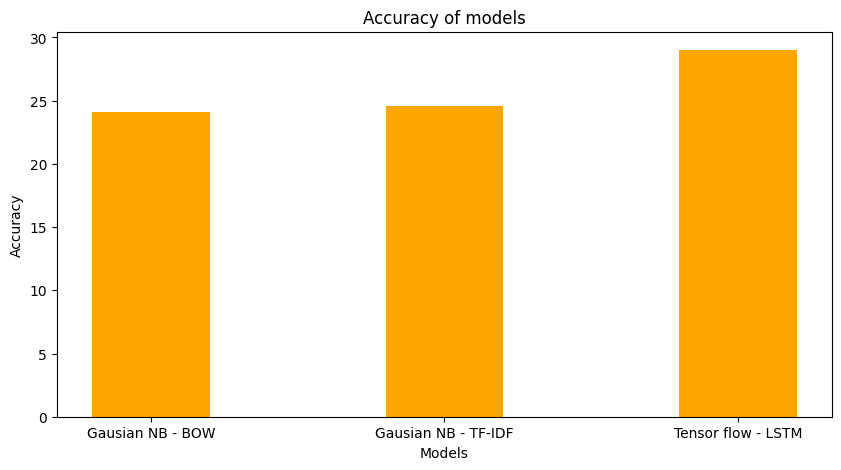

In [4]:
import matplotlib.pyplot as plt
data = {'Gausian NB - BOW':24.1, 'Gausian NB - TF-IDF':24.6, 'Tensor flow - LSTM':29,
        }
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='orange',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of models")

plt.savefig("accuracy.pdf")

In [ ]:
from google.colab import files
files.download('accuracy_analysis.pdf') 
